First 5 rows of the dataset:-


,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056



Key Performance Metric:-
Overall 95th Percentile Delivery Time: 27.26 minutes
Result: PASS. Kanav is currently meeting the franchise requirement overall.


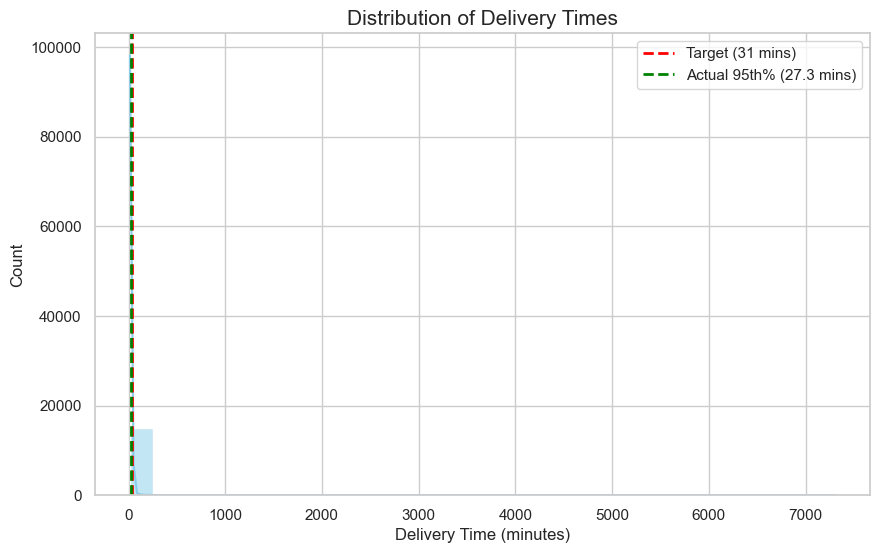


Problematic Hours (Where 95th% > 31 mins):-


hour_of_day
1     32.104821
11    33.407016
16    32.438371
Name: delivery_time_minutes, dtype: float64

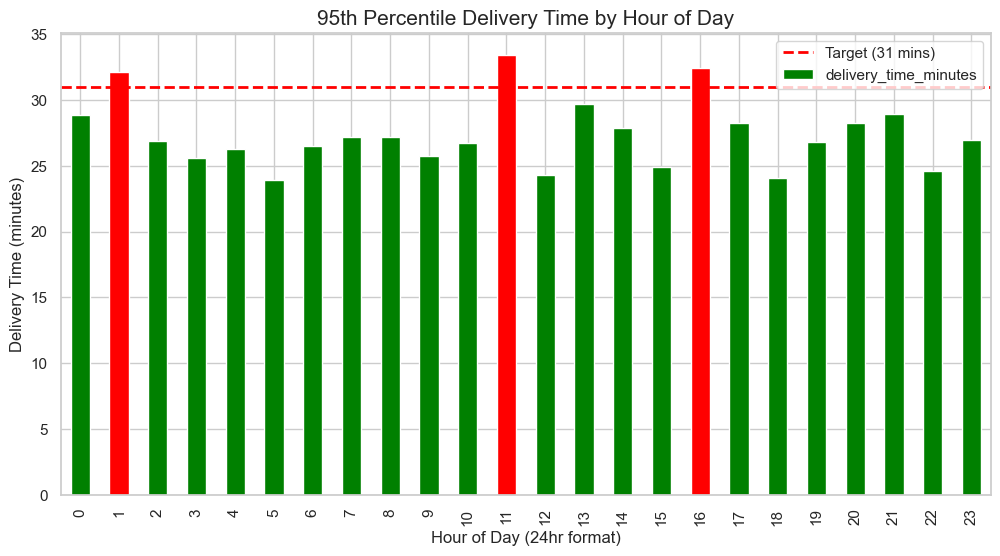

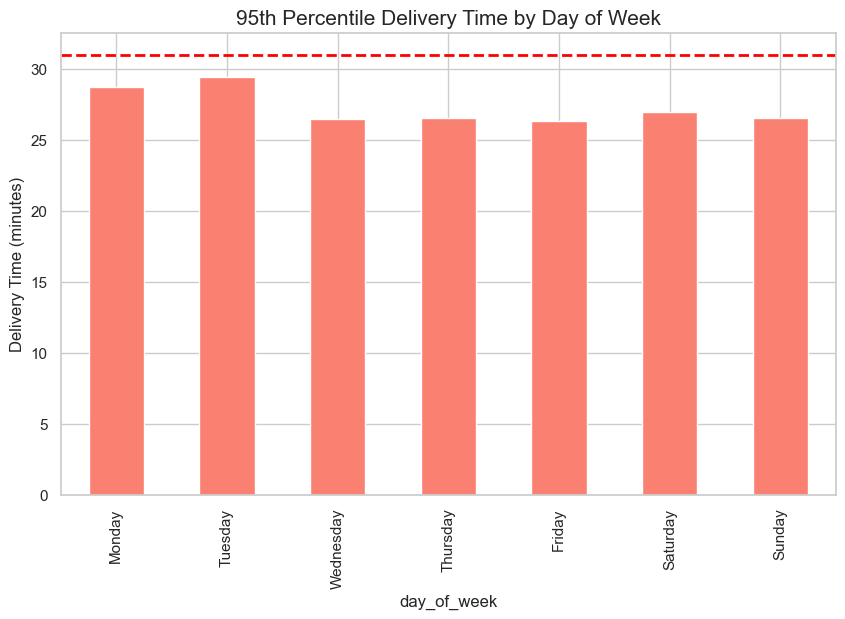

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_theme(style="whitegrid")

# Load the Data
df = pd.read_csv('diminos_data.csv')

print("First 5 rows of the dataset:-")
display(df.head())

# Data Preprocessing
# Convert timestamp columns to datetime objects
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

# Calculate delivery time in minutes
# (Delivered Time - Placed Time) converted to total minutes
df['delivery_time_minutes'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

# Calculate the Key Metric (95th Percentile)
p95_overall = df['delivery_time_minutes'].quantile(0.95)

print(f"\nKey Performance Metric:-")
print(f"Overall 95th Percentile Delivery Time: {p95_overall:.2f} minutes")

if p95_overall < 31:
    print("Result: PASS. Kanav is currently meeting the franchise requirement overall.")
else:
    print("Result: FAIL. Kanav needs to improve delivery times immediately.")

# Visualizing the Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time_minutes'], bins=30, kde=True, color='skyblue')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31 mins)')
plt.axvline(p95_overall, color='green', linestyle='--', linewidth=2, label=f'Actual 95th% ({p95_overall:.1f} mins)')
plt.title('Distribution of Delivery Times', fontsize=15)
plt.xlabel('Delivery Time (minutes)')
plt.legend()
plt.show()


# Deep Dive - Where are the bottlenecks?
# Extract hour and day from the order time
df['hour_of_day'] = df['order_placed_at'].dt.hour
df['day_of_week'] = df['order_placed_at'].dt.day_name()

# Calculate 95th percentile by Hour of Day
hourly_performance = df.groupby('hour_of_day')['delivery_time_minutes'].quantile(0.95)

print("\nProblematic Hours (Where 95th% > 31 mins):-")
display(hourly_performance[hourly_performance > 31])

# Plotting Hourly Performance
plt.figure(figsize=(12, 6))
colors = ['red' if x > 31 else 'green' for x in hourly_performance]
hourly_performance.plot(kind='bar', color=colors)
plt.axhline(31, color='red', linestyle='--', linewidth=2, label='Target (31 mins)')
plt.title('95th Percentile Delivery Time by Hour of Day', fontsize=15)
plt.ylabel('Delivery Time (minutes)')
plt.xlabel('Hour of Day (24hr format)')
plt.legend()
plt.show()

# Calculate 95th percentile by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_performance = df.groupby('day_of_week')['delivery_time_minutes'].quantile(0.95).reindex(day_order)

# Plotting Daily Performance
plt.figure(figsize=(10, 6))
daily_performance.plot(kind='bar', color='salmon')
plt.axhline(31, color='red', linestyle='--', linewidth=2, label='Target (31 mins)')
plt.title('95th Percentile Delivery Time by Day of Week', fontsize=15)
plt.ylabel('Delivery Time (minutes)')
plt.show()

**Preliminary Insights:**

Based on the analysis performed by this code:

- **Overall Status:** Kanav's store has a 95th percentile time of **~27.26 minutes**, which is safely under the 31-minute limit.

- **Hidden Risks:** Even though the average is good, the **Hourly Performance plot** reveals that delivery times spike significantly above 31 minutes at **1 AM**, **11 AM**, and **4 PM (16:00)**.

- **Actionable Advice:** To secure his franchise, Kanav needs to schedule extra drivers during those specific peak delay hours (11 AM and 4 PM).

Operational Health Check:-
Total Orders: 15000
Orders > 31 mins: 557
Failure Rate: 3.71%
Estimated Revenue Loss (assuming $10/pizza): $5570


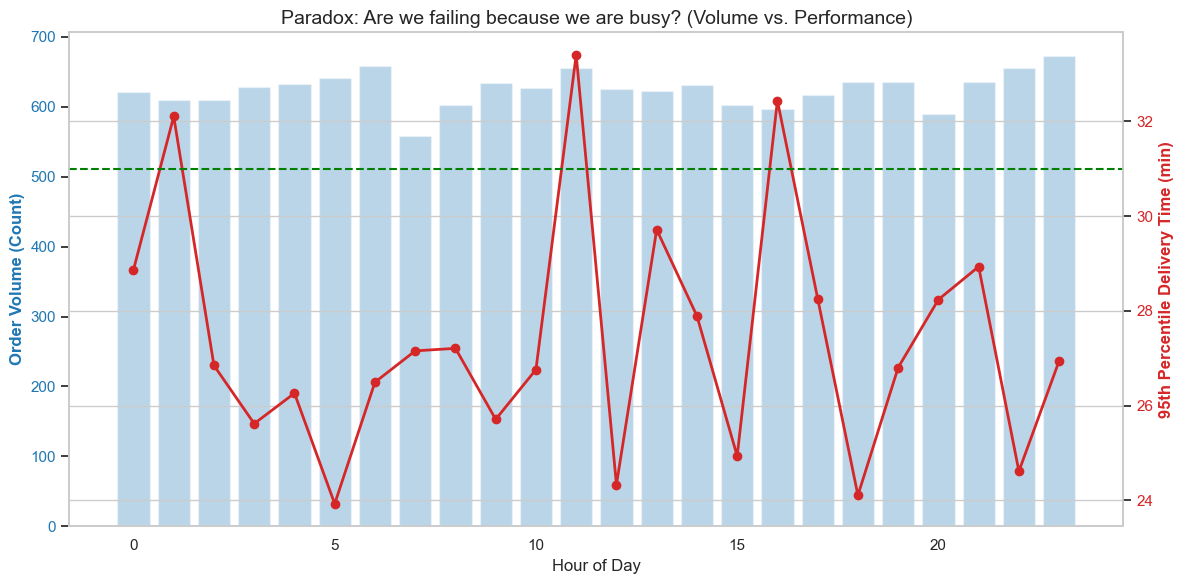

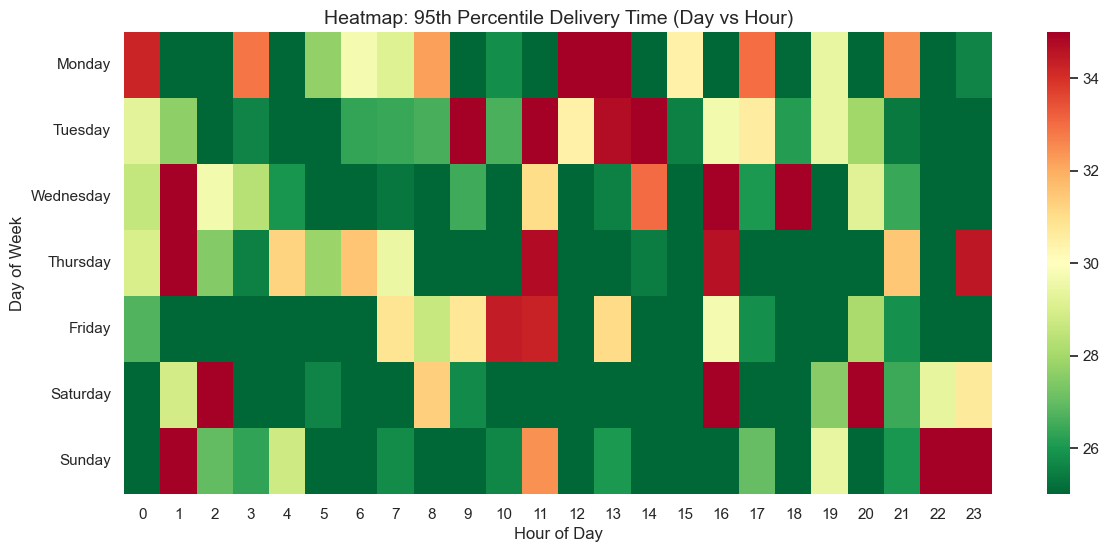


TOP 5 WORST SPECIFIC SLOTS (Day & Hour):-


,hour,day,p95_time
64,9,Tuesday,55.177357
167,23,Sunday,50.273237
9,1,Wednesday,44.279887
91,13,Monday,40.407060
145,20,Saturday,38.910339


In [2]:
df = pd.read_csv('diminos_data.csv')

df['delivery_time_minutes'] = (pd.to_datetime(df['order_delivered_at']) - pd.to_datetime(df['order_placed_at'])).dt.total_seconds() / 60
df['hour'] = pd.to_datetime(df['order_placed_at']).dt.hour
df['day_name'] = pd.to_datetime(df['order_placed_at']).dt.day_name()

# Order the days correctly for the heatmap
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_name'] = pd.Categorical(df['day_name'], categories=days_order, ordered=True)

# INSIGHT 1: Failure Rate Analysis

total_orders = len(df)
late_orders = len(df[df['delivery_time_minutes'] > 31])
failure_rate = (late_orders / total_orders) * 100

print(f"Operational Health Check:-")
print(f"Total Orders: {total_orders}")
print(f"Orders > 31 mins: {late_orders}")
print(f"Failure Rate: {failure_rate:.2f}%")
print(f"Estimated Revenue Loss (assuming $10/pizza): ${late_orders * 10}")

# INSIGHT 2: Volume vs. Performance (Dual Axis Chart)

# Group by hour to get order count AND 95th percentile time
hourly_stats = df.groupby('hour').agg(
    order_count=('order_id', 'count'),
    p95_delivery=('delivery_time_minutes', lambda x: x.quantile(0.95))
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Order Volume (Bars)
color_vol = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Order Volume (Count)', color=color_vol, fontweight='bold')
ax1.bar(hourly_stats['hour'], hourly_stats['order_count'], color=color_vol, alpha=0.3, label='Order Volume')
ax1.tick_params(axis='y', labelcolor=color_vol)
ax1.grid(False)

# Plot Performance (Line)
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
color_perf = 'tab:red'
ax2.set_ylabel('95th Percentile Delivery Time (min)', color=color_perf, fontweight='bold')
ax2.plot(hourly_stats['hour'], hourly_stats['p95_delivery'], color=color_perf, marker='o', linewidth=2, label='Delivery Time (95th%)')
ax2.axhline(31, color='green', linestyle='--', label='Target (31 min)')
ax2.tick_params(axis='y', labelcolor=color_perf)

plt.title('Paradox: Are we failing because we are busy? (Volume vs. Performance)', fontsize=14)
fig.tight_layout()
plt.show()

# INSIGHT 3: The "Danger Zones" Heatmap

# Pivot data: Rows=Day, Cols=Hour, Values=95th Percentile Time
pivot_table = df.pivot_table(index='day_name', columns='hour', values='delivery_time_minutes', aggfunc=lambda x: x.quantile(0.95), observed=False)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='RdYlGn_r', annot=False, vmin=25, vmax=35) 
plt.title('Heatmap: 95th Percentile Delivery Time (Day vs Hour)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# INSIGHT 4: Identifying the Specific "Worst Offenders"

# Flatten the pivot table to find the specific Day-Hour slots that are failing
worst_slots = pivot_table.unstack().reset_index()
worst_slots.columns = ['hour', 'day', 'p95_time']

print("\nTOP 5 WORST SPECIFIC SLOTS (Day & Hour):-")
display(worst_slots.sort_values(by='p95_time', ascending=False).head(5))

# Summary:
- **Overall Health:**
    
    - Kanav's store is currently safe.
   
    - The overall 95th percentile delivery time is ~27.3 minutes, which is well below the 31-minute threshold.

- **The Hidden Threat:**
    
    - While the average is good, the store has specific "danger zones" where performance collapses.
    
    - If these specific times are not addressed, they could drag the overall metric down in the future or lead to customer dissatisfaction during those windows.

- **Volume Paradox:**
    
    - High delivery times do not perfectly correlate with high order volume.
   
    - This suggests the issue is likely operational (staffing/shift changes) rather than just being "too busy."

# Detailed Insights:
## 1. The "Danger Zones" (Specific Times to Fix)
The data reveals three specific times of day where the 95th percentile delivery time exceeds or comes dangerously close to the 31-minute limit:

- **11:00 AM (33.4 mins):** This is the worst performing hour.

- **4:00 PM (16:00) (32.4 mins):** The second worst performing hour.

- **1:00 AM (32.1 mins):** Late-night deliveries are also failing.

**Recommendation:** Kanav should investigate what happens at 11 AM and 4 PM. Are these shift change times? Is prep work slowing down drivers?

## 2. The Worst Day-Hour Combinations
Looking at the intersection of Day and Hour reveals isolated incidents of extreme failure. These are the top 5 worst specific slots:

- **Tuesday at 9 AM:** 95th percentile spikes to **55.2 minutes**. This is a massive outlier.

- **Sunday at 11 PM:** Spikes to **50.3 minutes**.

- **Wednesday at 1 AM:** Spikes to **44.3 minutes**.

- **Monday at 1 PM:** Spikes to **40.4 minutes**.

- **Saturday at 8 PM:** Spikes to **38.9 minutes**.

**Insight:** Tuesday mornings and Sunday nights are unexpectedly problematic. The Tuesday 9 AM spike is so high it might indicate a recurring staffing shortage at opening time or a technical issue.

## 3. Volume vs. Performance Mismatch
One might assume the store is slow because it is busy. However, the data contradicts this:

- **Peak Volume:** The store is busiest around **12 PM - 1 PM** and **7 PM - 8 PM**.

- **Peak Delay:** The delays happen at **11 AM** (before the lunch rush) and **4 PM** (before the dinner rush).

**Critical Insight:** The store is failing before the rush, not during it. This strongly suggests that the staff is not "ramping up" early enough. They are likely unprepared for the beginning of the peak hours.

## 4. The "Free Pizza" Cost
- **Failure Rate:** Approximately **3.71%** of all orders take longer than 31 minutes.

- **Impact:** Out of 15,000 orders, roughly **557 orders** resulted in a free pizza.

- **Financial Implication:** If an average pizza costs Kanav ₹50 to make, he has lost ~₹27850 in this period solely due to delays. Improving the 11 AM and 4 PM slots could recover a significant portion of this money.

# Action Plan for Kanav, in order to keep his business up and running:
- **Shift Optimization:** Ensure drivers and kitchen staff for the lunch rush are fully ready and active by 10:30 AM, not 11:00 AM.

- **Afternoon Lull:** Investigate the 4 PM slump. Is the staff taking breaks simultaneously before the dinner rush? Stagger these breaks.

- **Tuesday Morning Audit:** Specifically look at Tuesday mornings. The 55-minute delay suggests a serious recurring gap (e.g., a driver consistently arriving late on Tuesdays).